## Portfolio Hedging using VIX 

In this notebook, we will be using the concept of Bollinger bands to decide weither to go long or short on VIXY.

We will perform the following steps:
1. [Import the necessary libraries](#import)
2. [Read the data](#data)
3. [Strategy parameters](#param)
4. [Calculate daily returns](#strategy_returns)
4. [Calculate daily strategy returns for combined portfolio](#daily_strategy_returns)
5. [Calculate and plot cumulative strategy returns](#cum_returns)
6. [Conclusion](#conclusion)

In [1]:
# Data analysis and manipulation
import numpy as np
import pandas as pd

# Technical indicators
import talib as ta

#For strategy analysis
import pyfolio as pf

# Plot data in seaborn-darkgrid style
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# To ignore unwanted warnings
import warnings
warnings.filterwarnings("ignore")

/Users/hichemheddar/anaconda3/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(
/var/folders/cp/bkd_fjpn4h3g5xz9g867z6cw0000gn/T/ipykernel_13486/2385354534.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


<a id='data'></a> 
## Read the data

The OHLCV data for the SPY and VIXY is stored in the CSV files.

In [2]:
prices = pd.DataFrame()

# The data is stored in the directory 'data_modules'
path = './data_modules/'

# Read the daily SPY and VIXY data
prices['SPY'] = pd.read_csv(path + 'SPY_2011_2022.csv', index_col=0)['Adj Close']
prices['VIXY'] = pd.read_csv(path + 'VIXY_2011_2022.csv', index_col=0)['Adj Close']
prices.index = pd.to_datetime(prices.index)
prices

,SPY,VIXY
Date,,
2011-02-28,107.349419,26216.000000
2011-03-01,105.559593,28132.000000
2011-03-02,105.785355,28240.000000
2011-03-03,107.607445,26780.000000
2011-03-04,106.801163,27544.000000
...,...,...
2022-02-22,428.239624,19.090000
2022-02-23,420.643219,20.150000
2022-02-24,426.973541,19.520000


<a id='param'></a> 
## Strategy parameters

1. For the sake of simplicity the hedge ratio is taken as 0.5 i.e. for every 1 contract of SPY we will have 0.5 contract of VIXY
2. Calculate 5 period SMA (timeperiod = 5) of Adjusted Close price using talib library. 
3. Calculate 60 period Bollinger bands (timeperiod = 60) with standard deviation from middle band as 1.5 (nbdevup = 1.5)

In [3]:
# Define the hedge_ratio
hedge_ratio = 0.5

# Calculate 5 period SMA (Closing price)
prices['VIXY_ma5'] = ta.MA(prices['VIXY'], timeperiod=5)

# Calculate the value of upper Bollinger band
prices['VIXY_upperB'],prices['VIXY_middleB'],prices['VIXY_lowerB'] = ta.BBANDS(prices['VIXY'], timeperiod=60, nbdevup=1.5)

<a id='strategy_returns'></a> 
## Calculate daily returns

1. Calculate the daily returns of SPY and VIXY. Daily returns are calculated by taking the percentage change of the closing price. 
2. The daily returns for VIXY are multiplied by the hedge ratio because the capital allocation for VIXY and SPY is done in the ratio of hedge ratio.
3. Buy signal for VIXY when 5-SMA > Upper Bollinger band. Buy signal is taken as 1 and no position is taken as 0.
4. Sell signal for VIXY when 5-SMA < Lower Bollinger band.
5. When there is no position in VIXY the part of capital which gets allocated to VIXY is available as cash margin.
6. Multiply the generated buy signal with daily VIXY returns.

In [4]:
# Calculate the daily returns of SPY and VIXY
returns = prices[['SPY','VIXY']].pct_change().dropna()

# Multiply VIXY daily returns by hedge ratio
returns.VIXY *= hedge_ratio

# Generate buy signal when 5-SMA > Bollinger upper band
prices['signal'] = np.where(prices['VIXY_ma5'] >= prices['VIXY_upperB'], 1, 0)

prices['signal'] = np.where(prices['VIXY_ma5'] <= prices['VIXY_lowerB'], -1, 0)

# Multiplying generated signal with VIXY daily returns
returns.VIXY = prices['signal'] * (returns.VIXY.shift(-1))

<a id='daily_strategy_returns'></a> 
## Calculate daily strategy returns for combined portfolio

1. The combined portfolio in this strategy would contain 1 quantity of SPY and 0.5 quantity of VIXY.
2. Calculate the sum of all returns across both the assets.
3. Divide the net sum by the total quantity of assets which is (1 + hedge_ratio).

In [5]:
# Calculate strategy returns for combined portfolio
returns['portfolio_returns'] = (returns.sum(axis=1))/(1 + hedge_ratio)

<a id='cum_returns'></a> 
## Calculate and plot cumulative strategy returns

You will calculate cumulative strategy returns and plot it using the Matplotlib library.

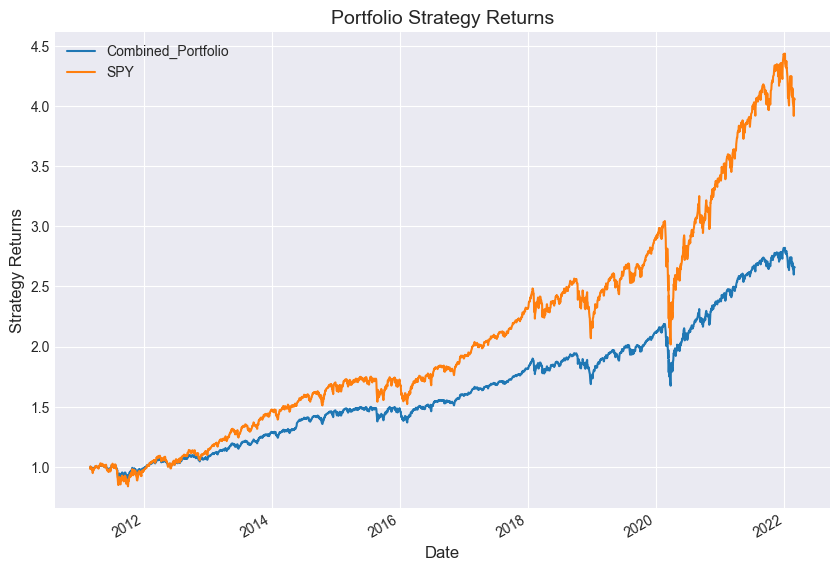

In [6]:
# Calculate cumulative returns for SPY
returns['cum_SPY_returns'] = (returns['SPY'] + 1).cumprod()

# Calculate cumulative returns for combined portfolio (VIXY + SPY)
returns['cum_portfolio_returns'] = (returns['portfolio_returns'] + 1).cumprod()

# Plot cumulative strategy returns
returns['cum_portfolio_returns'].plot(figsize=(10, 7), label = "Combined_Portfolio")
returns['cum_SPY_returns'].plot(figsize=(10, 7), label = "SPY")
plt.legend()
plt.title('Portfolio Strategy Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Strategy Returns', fontsize=12)
plt.show()

Start date,2011-03-01
End date,2022-02-28
Total months,131
,Backtest
Annual return,9.3%
Cumulative returns,165.9%
Annual volatility,11.3%
Sharpe ratio,0.84
Calmar ratio,0.40
Stability,0.97
Max drawdown,-23.5%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.47,2020-02-19,2020-03-23,2020-08-04,120
1,13.24,2018-09-20,2018-12-24,2019-04-05,142
2,12.52,2011-04-29,2011-10-03,2012-02-03,201
3,8.67,2015-07-20,2016-02-11,2016-04-18,196
4,7.88,2022-01-03,2022-02-23,NaT,NaN


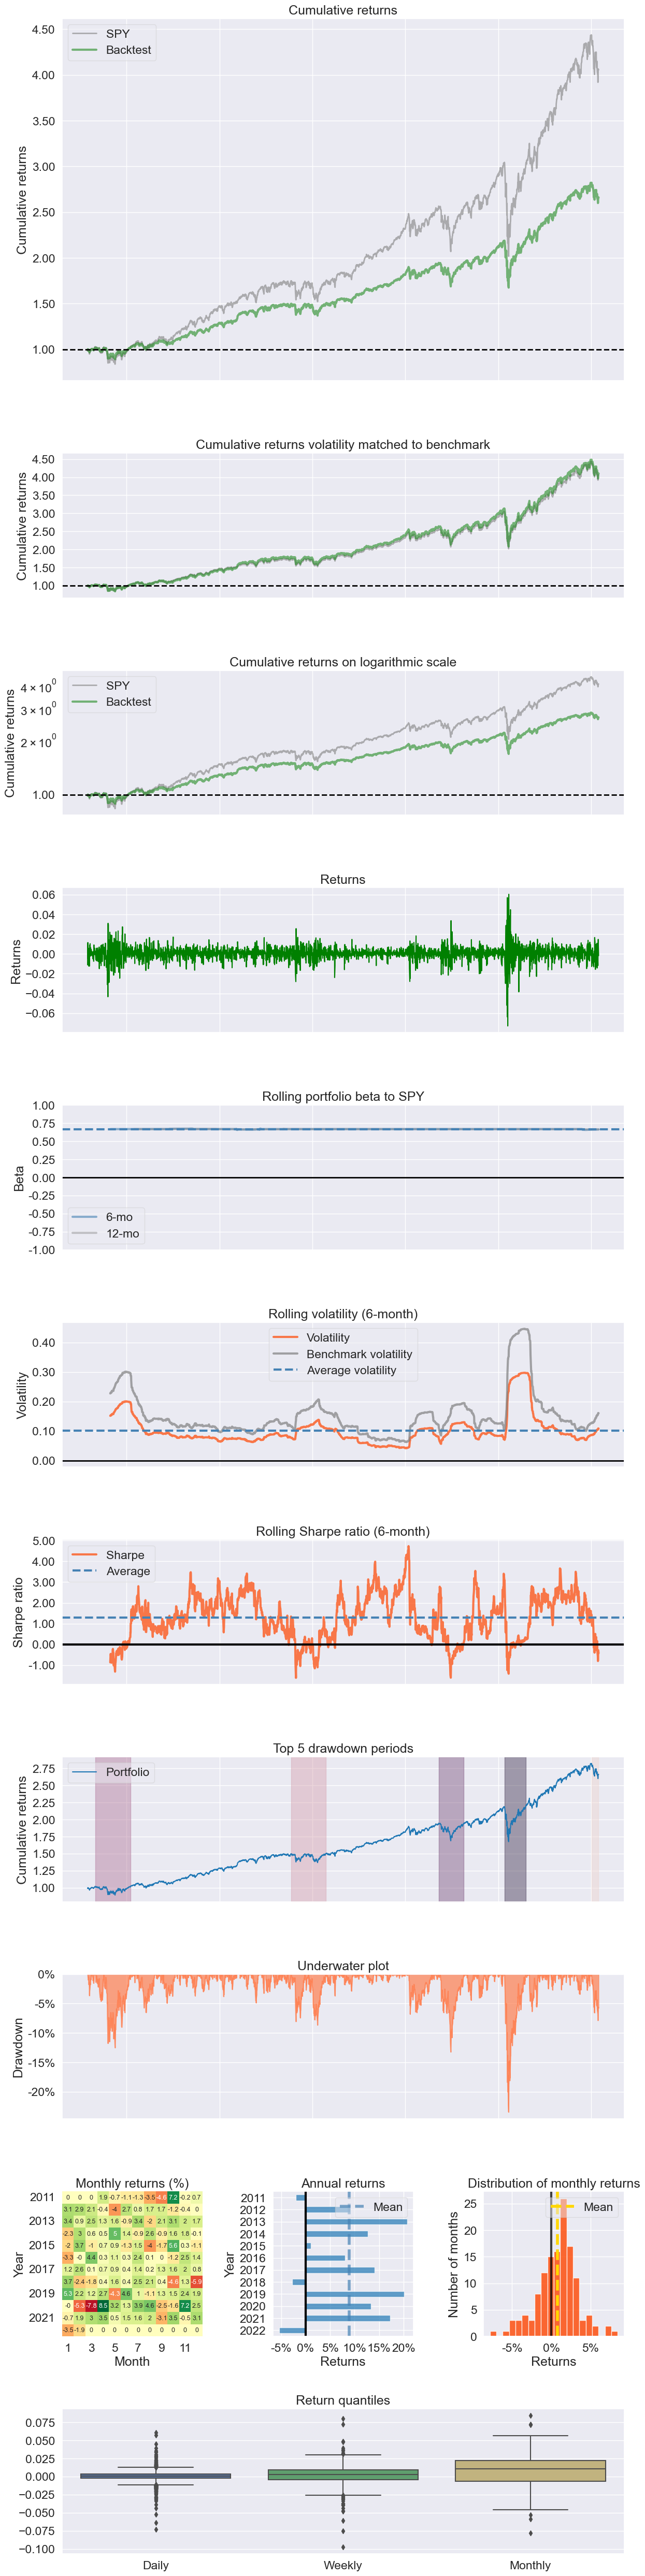

In [16]:
# Creating pyfolio tear sheet
pf.create_returns_tear_sheet(returns['portfolio_returns'], benchmark_rets = returns['SPY'])